In [1]:
import numpy as np
import jax
from jax import jit, vmap, grad, random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from scipy.optimize import fsolve, root, bisect

%config InlineBackend.figure_format = 'retina'

sns.set_style('whitegrid')
!nvidia-smi

Sun Mar 31 15:00:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:CA:00.0 Off |                    0 |
| N/A   25C    P0              48W / 400W |      4MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
def df_1(etas, lamb):
  return jnp.mean(etas/(lamb+etas))

def df_2(etas, lamb):
  return jnp.mean((etas/(lamb+etas))**2)

def tf_1(etas, ws, lamb):
  return jnp.sum((ws**2) * etas/(lamb+etas))

def tf_1p(etas, ws, lamb):
  return jnp.sum((ws**2)*etas/(lamb+etas)**2)

def tf_2(etas, ws, lamb):
  return jnp.sum((ws**2) * etas**2/(lamb+etas)**2)

def newton(f, x0, max_step=100, abs_tol=1e-5, rel_tol=1e-10, eta=1.0):
    x = x0
    gf = grad(f)
    for _ in range(max_step):
        x_next = x - eta*f(x)/gf(x)
        if abs(f(x_next)) < abs_tol:
            return x_next
        x = x_next
    return None

def df_1_bar(etas, lamb, sigma):
  return jnp.mean(etas/(lamb+etas)) + sigma/lamb

def solve_kappa2(P, D, N, lamb, etaX, sigma=0.0, upper_bound=None):
  if not upper_bound:
    upper_bound = lamb + 1e3
  if lamb == 0:
    if D == min(D, P, N):
      return 0
    elif P == min(D, P, N):
      fn = lambda kappa: 1 - D/P * df_1_bar(etaX, kappa, sigma)
    else:
      fn = lambda kappa: N/D - df_1_bar(etaX, kappa, sigma)
  else:
    fn = lambda kappa: kappa * (N/D - df_1_bar(etaX, kappa, sigma))*(1 - D/P * df_1_bar(etaX, kappa, sigma)) - lamb
  return newton(fn, x0=upper_bound)

def solve_kappa2_deep(P, Ns:list, lamb, etaX, upper_bound=1e3, eta=1.0):
  D = Ns[0]
  if lamb == 0:
    if D == min(P, *Ns):
      return 0
    elif P == min(P, *Ns):
      fn = lambda kappa: 1 - D/P * df_1(etaX, kappa)
    else:
      N = min(Ns)
      fn = lambda kappa: N/D - df_1(etaX, kappa)
  else:
    def fn(kappa):
      ans = kappa * (1 - D/P * df_1(etaX, kappa))
      for N in Ns[1:]:
        ans *= N/D - df_1(etaX, kappa)
      return ans - lamb
  return newton(fn, x0=upper_bound, eta=eta)

def estimate_kappa(q, lamb, etas):
  return lamb/(1-q*df_1(etas, lamb))

def mean_std(y):
  return (jnp.mean(y).item, jnp.std(y).item)

def cantor_pairing(i, j):
  return (i + j) * (i + j + 1) // 2 + j


In [4]:
Egs = defaultdict(list)
Egs_clean = defaultdict(list)
Etrs = defaultdict(list)
Biases = []
VarXs = []
VarFs = []
VarXFs = []
VarXes = []
VarXFes = []
kappa_emp_guess = defaultdict(list)
qs = np.logspace(-2, 2, 20)
P_te = 200
sigma_epsilon = 0.0
sigma_xi = 1.0

D = 200
N = 100
F_seeds = list(range(10))
X_seeds = list(range(10))

b1 = 0.0
b2 = 0.0
a = 0.0
lamb = 1e-4

etasX = jnp.arange(1, D+1)**(-b1)
etasF = jnp.arange(1, N+1)**(-b2)
SX = jnp.diag(etasX)
SF = jnp.diag(etasF)
w = jnp.arange(1, D+1)**(-a+b1)
w = w / jnp.sqrt(jnp.sum(w**2))

X_te_key, Xi_te_key = random.split(random.PRNGKey(0))
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(SX)
Xi_te = random.normal(Xi_te_key, (P_te, N)) * sigma_xi
y_te = X_te @ w

print(f"D = {D}, N = {N}")
for q in tqdm(qs):
  P = int(D/q)

  y_hats = np.zeros((len(X_seeds), len(F_seeds), P_te))
  y_hats_clean = np.zeros((len(X_seeds), len(F_seeds), P_te))
  for X_seed in X_seeds:
    key = random.PRNGKey(X_seed)
    X_tr_key, _ = random.split(key)
    e_key, _ = random.split(X_tr_key)

    epsilon = random.normal(e_key, (P, )) * sigma_epsilon
    X_tr = random.normal(X_tr_key, (P, D)) @ jnp.sqrt(SX)
    y_tr = X_tr @ w + epsilon
    y_tr_clean = X_tr @ w

    for F_seed in F_seeds:
      F_key = random.PRNGKey(F_seed)
      Xi_key = random.PRNGKey(cantor_pairing(X_seed, F_seed))
      F = random.normal(F_key, (D, N)) /np.sqrt(D)
      Xi = random.normal(Xi_key, (P, N)) * sigma_xi
      FX_tr = (X_tr @ F + Xi)
      FX_te = (X_te @ F + Xi_te)
      if P > 0.8 * D:
        cov = FX_tr.T @ FX_tr
        if P > 1.2 * D:
          hat_op = jnp.linalg.inv(cov + P*lamb*np.identity(N)) @ FX_tr.T
        else:
          hat_op = jnp.linalg.pinv(cov + P*lamb*np.identity(N)) @ FX_tr.T
        y_hat_te = FX_te @ hat_op @ y_tr
        y_hat_te_clean = FX_te @ hat_op @ y_tr_clean
        y_hat_tr = FX_tr @ hat_op @ y_tr
        E_tr = jnp.mean((y_tr - y_hat_tr)**2).item()
      else: 
        gram = FX_tr @ FX_tr.T
        hat_op = jnp.linalg.inv(gram + P*lamb*np.identity(P))
        y_hat_te = FX_te @ FX_tr.T @ hat_op @ y_tr
        y_hat_te_clean = FX_te @ FX_tr.T @ hat_op @ y_tr_clean
        E_tr = lamb**2/P * jnp.linalg.norm((jnp.linalg.inv(gram/P + lamb*np.identity(P))) @ y_tr)**2

      E_g = jnp.mean((y_te - y_hat_te) ** 2).item()
      E_g_clean = jnp.mean((y_te - y_hat_te_clean) ** 2).item()

      Etrs[q].append(E_tr)
      Egs[q].append(E_g)

      y_hats[X_seed, F_seed, :] = y_hat_te
      y_hats_clean[X_seed, F_seed, :] = y_hat_te_clean
      if P < 1.2 * D:
        gram = FX_tr @ FX_tr.T
        kappa_emp_guess[q].append((jnp.trace(jnp.linalg.inv(gram + P*lamb*np.identity(P))))**(-1))
      else:
        cov = FX_tr.T @ FX_tr
        df_F = jnp.trace(cov @ jnp.linalg.inv(cov + P*lamb*np.identity(N)))
        kappa_emp_guess[q].append( lamb / (1 - 1/P * df_F) )

  Eg = jnp.mean((y_hats - y_te[None, None, :])**2).item()
  Signal = jnp.mean((y_hats_clean - y_te[None, None, :])**2).item()
  Noise = jnp.mean((y_hats - y_hats_clean)**2).item()
  Biases.append(  jnp.mean((y_te - np.mean(y_hats_clean, axis=(0, 1)))**2).item() )
  VarXs.append(   jnp.mean((jnp.mean(y_hats_clean, axis=1) - y_te[None, :])**2).item() - Biases[-1] )
  VarFs.append(   jnp.mean((jnp.mean(y_hats_clean, axis=0) - y_te[None, :])**2).item() - Biases[-1] )
  VarXFs.append(   Signal - VarXs[-1] - VarFs[-1] - Biases[-1])
  VarXes.append( jnp.mean((jnp.mean(y_hats - y_hats_clean, axis=1))**2) )
  VarXFes.append( Noise - VarXes[-1])


D = 200, N = 100


100%|██████████| 20/20 [01:01<00:00,  3.05s/it]


Text(0.5, 1.0, 'NLRF, $\\lambda=$0.0001, $\\sigma_\\epsilon=$0.0')

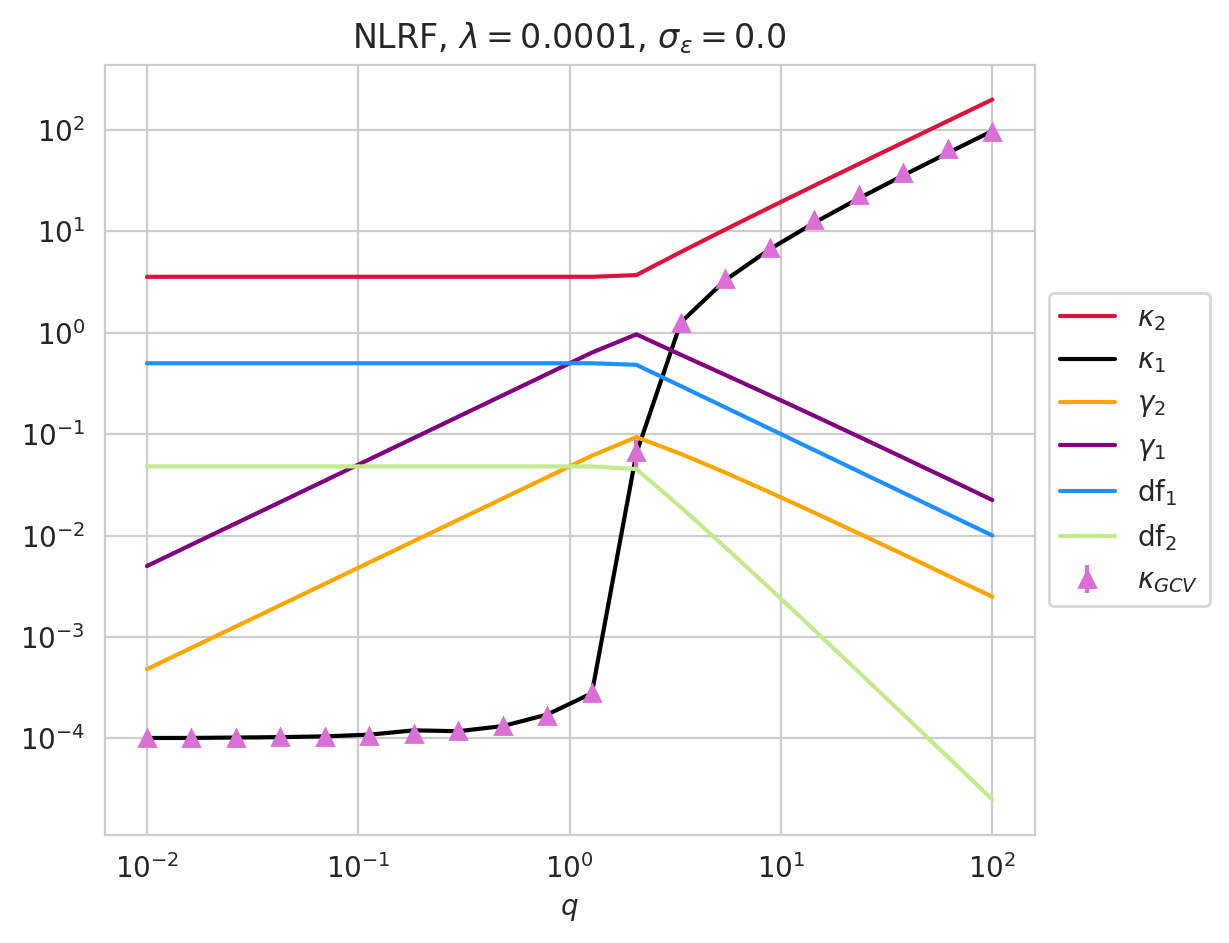

In [5]:
# q is D/P
qs2 = qs 
kappa2 = jnp.array([solve_kappa2(D/q, D, N, lamb=lamb, sigma=sigma_xi, etaX=etasX) for q in qs2])
df1k2 = jnp.array([df_1_bar(etasX, k, sigma_xi) for k in kappa2])
df2k2 = jnp.array([df_2(etasX, k) for k in kappa2])
tf1pk2 = jnp.array([tf_1p(etasX, w, k) for k in kappa2])
tf1k2 = jnp.array([tf_1(etasX, w, k) for k in kappa2])
tf2k2 = jnp.array([tf_2(etasX, w, k) for k in kappa2])
gamma2 = qs2 * df2k2
kappa1 = kappa2 * (N/D - df1k2)
dlogS = df1k2/(N/D - df1k2)
dlogk1k2 = 1 + (df1k2-df2k2)/df1k2 * dlogS
dlogk2k1 = 1/dlogk1k2

gamma1 = qs2 * df1k2 * (1 - (df1k2 - df2k2)/df1k2 * dlogk2k1)

kappaGCV = np.array([np.mean(kappa_emp_guess[q]) for q in qs])
kappaGCV_std = np.array([np.std(kappa_emp_guess[q]) for q in qs])
Ss_emp_std = np.array([np.std(kappa_emp_guess[q]) for q in qs])/lamb

sns.set_palette('rainbow', n_colors=7)
plt.figure(figsize=(6, 5))
plt.plot(qs2, kappa2, label="$\\kappa_2$", c='crimson')
plt.plot(qs2, kappa1, label="$\\kappa_1$", c='k')
plt.errorbar(qs, kappaGCV, kappaGCV_std, label="$\\kappa_{GCV}$", c='orchid', marker='^', linestyle="")

plt.plot(qs2, gamma2, label="$\\gamma_2$", c='orange')
plt.plot(qs2, gamma1, label="$\\gamma_1$", c='purple')

plt.plot(qs2, df1k2, label="df$_1$", c='dodgerblue')
plt.plot(qs2, df2k2, label="df$_2$", c='C4')

# plt.plot(qs2, dlogk2k1, label="dlogk2k1", c='C1')

# plt.errorbar(qs2, [np.mean(df1_empirical[q]) for q in qs], [np.std(df1_empirical[q]) for q in qs] , marker='o', linestyle="", label="df$_1$ emp", c='C6')

# plt.plot(qs, Ss, c='forestgreen', label="$S$")
# plt.errorbar(qs, Ss_emp, Ss_emp_std, marker='o', linestyle='', c='forestgreen', label='$S$ emp')
# Put the legent to the right of the actual plot:
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$q$')
plt.title(f"NLRF, $\\lambda=${lamb}, $\\sigma_\\epsilon=${sigma_epsilon}")

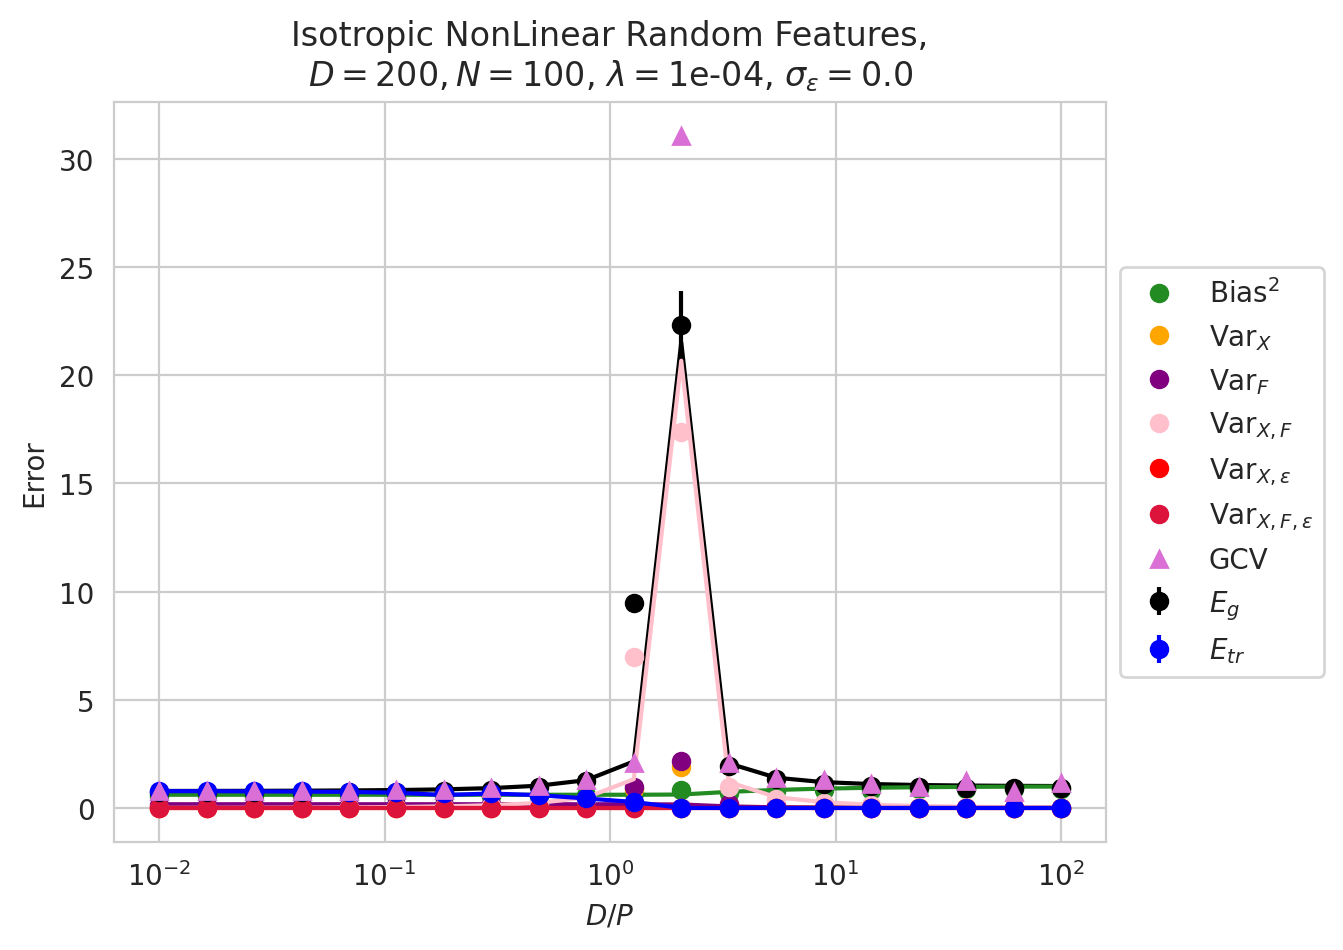

In [9]:
Eg_means = np.array([np.mean(Egs[q]) for q in qs])
Eg_stds = np.array([np.std(Egs[q]) for q in qs])/10
Etr_means = np.array([np.mean(Etrs[q]) for q in qs])
Etr_stds = np.array([np.std(Etrs[q]) for q in qs])

signal = (kappa2**2 * tf1pk2 * dlogk2k1 + kappa2*tf1k2 * ( 1 - dlogk2k1) ) /(1-gamma1)
noise = sigma_epsilon**2 * gamma1/(1-gamma1)
Eg_theory = signal + noise
bias = kappa2**2 * tf1pk2
varX = kappa2**2 * tf1pk2 * gamma2/(1-gamma2)
varXe = sigma_epsilon**2 * gamma2/(1-gamma2)
varXFe = noise - varXe
varF = (1 - dlogk2k1) * kappa2 * tf2k2
varXF = signal - varX - varF - bias

Etr_theory = ((lamb/kappa1)**2)*(Eg_theory + sigma_epsilon**2)

plt.errorbar(qs, Eg_means, Eg_stds, c='k', marker='o', linestyle='', label='$E_{g}$')
plt.plot(qs2,  Eg_theory, c='k')
# plt.plot(qs, (np.array(kappaGCV)/lamb)**2 * ((lamb/kappa)**2)*(Eg_theory + sigma_epsilon**2)  - sigma_epsilon**2 , c='grey', marker='o', linestyle='', label='GCV')

plt.plot(qs2, bias, c='forestgreen')
plt.plot(qs, Biases, c='forestgreen', marker='o', linestyle='', label="Bias$^2$")
plt.plot(qs2, varX, c='orange')
plt.plot(qs, VarXs, c='orange', marker='o', linestyle='', label='Var$_{{X}}$')
plt.plot(qs2, varF, c='purple')
plt.plot(qs, VarFs, c='purple', marker='o', linestyle='', label='Var$_{{F}}$')
plt.plot(qs2, varXF, c='pink')
plt.plot(qs, VarXFs, c='pink', marker='o', linestyle='', label='Var$_{{X, F}}$')
plt.plot(qs2, varXe, c='red')
plt.plot(qs, VarXes, c='red', marker='o', linestyle='', label='Var$_{{X, \epsilon}}$')
plt.plot(qs2, varXFe, c='crimson')
plt.plot(qs, VarXFes, c='crimson', marker='o', linestyle='', label='Var$_{{X, F, \epsilon}}$')


plt.plot(qs, (np.array(kappaGCV)/lamb)**2 * Etr_means - sigma_epsilon**2 , c='orchid', marker='^', linestyle='', label='GCV', zorder=3)

plt.errorbar(qs, Etr_means, Etr_stds, c='b', marker='o', linestyle='', label='$E_{tr}$')
plt.plot(qs2, Etr_theory, c='b')


plt.xlabel(r'$D/P$')
plt.ylabel('Error')
# plt.xlim(1, 1e2) 
# plt.ylim(1e-7, 1e2)
plt.xscale('log')
# plt.yscale('log')
plt.title(f"Isotropic NonLinear Random Features,\n$D={D}, N={N}$, $\\lambda=${lamb:.0e}, $\\sigma_\\epsilon=${sigma_epsilon}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Structured

In [11]:
Egs = defaultdict(list)
Egs_clean = defaultdict(list)
Etrs = defaultdict(list)
Biases = []
VarXs = []
VarFs = []
VarXFs = []
VarXes = []
VarXFes = []
kappa_emp_guess = defaultdict(list)
qs = np.logspace(1, 3, 20)
P_te = 200
sigma_epsilon = 0.0
sigma_xi = 1.0

D = 1000
N = 800
F_seeds = list(range(10))
X_seeds = list(range(10))

b1 = 1.2
b2 = 0.0
a = 1.2
lamb = 1e-4

etasX = jnp.arange(1, D+1)**(-b1)
etasF = jnp.arange(1, N+1)**(-b2)
SX = jnp.diag(etasX)
SF = jnp.diag(etasF)
w = jnp.arange(1, D+1)**(-a+b1)
w = w / jnp.sqrt(jnp.sum(w**2))

X_te_key, Xi_te_key = random.split(random.PRNGKey(0))
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(SX)
Xi_te = random.normal(Xi_te_key, (P_te, N)) * sigma_xi
y_te = X_te @ w

print(f"D = {D}, N = {N}")
for q in tqdm(qs):
  P = int(D/q)

  y_hats = np.zeros((len(X_seeds), len(F_seeds), P_te))
  y_hats_clean = np.zeros((len(X_seeds), len(F_seeds), P_te))
  for X_seed in X_seeds:
    key = random.PRNGKey(X_seed)
    X_tr_key, _ = random.split(key)
    e_key, _ = random.split(X_tr_key)

    epsilon = random.normal(e_key, (P, )) * sigma_epsilon
    X_tr = random.normal(X_tr_key, (P, D)) @ jnp.sqrt(SX)
    y_tr = X_tr @ w + epsilon
    y_tr_clean = X_tr @ w

    for F_seed in F_seeds:
      F_key = random.PRNGKey(F_seed)
      Xi_key = random.PRNGKey(cantor_pairing(X_seed, F_seed))
      F = random.normal(F_key, (D, N)) /np.sqrt(D)
      Xi = random.normal(Xi_key, (P, N)) * sigma_xi
      FX_tr = (X_tr @ F + Xi)
      FX_te = (X_te @ F + Xi_te)
      if P > 0.8 * D:
        cov = FX_tr.T @ FX_tr
        if P > 1.2 * D:
          hat_op = jnp.linalg.inv(cov + P*lamb*np.identity(N)) @ FX_tr.T
        else:
          hat_op = jnp.linalg.pinv(cov + P*lamb*np.identity(N)) @ FX_tr.T
        y_hat_te = FX_te @ hat_op @ y_tr
        y_hat_te_clean = FX_te @ hat_op @ y_tr_clean
        y_hat_tr = FX_tr @ hat_op @ y_tr
        E_tr = jnp.mean((y_tr - y_hat_tr)**2).item()
      else: 
        gram = FX_tr @ FX_tr.T
        hat_op = jnp.linalg.inv(gram + P*lamb*np.identity(P))
        y_hat_te = FX_te @ FX_tr.T @ hat_op @ y_tr
        y_hat_te_clean = FX_te @ FX_tr.T @ hat_op @ y_tr_clean
        E_tr = lamb**2/P * jnp.linalg.norm((jnp.linalg.inv(gram/P + lamb*np.identity(P))) @ y_tr)**2

      E_g = jnp.mean((y_te - y_hat_te) ** 2).item()
      E_g_clean = jnp.mean((y_te - y_hat_te_clean) ** 2).item()

      Etrs[q].append(E_tr)
      Egs[q].append(E_g)

      y_hats[X_seed, F_seed, :] = y_hat_te
      y_hats_clean[X_seed, F_seed, :] = y_hat_te_clean
      if P < 1.2 * D:
        gram = FX_tr @ FX_tr.T
        kappa_emp_guess[q].append((jnp.trace(jnp.linalg.inv(gram + P*lamb*np.identity(P))))**(-1))
      else:
        cov = FX_tr.T @ FX_tr
        df_F = jnp.trace(cov @ jnp.linalg.inv(cov + P*lamb*np.identity(N)))
        kappa_emp_guess[q].append( lamb / (1 - 1/P * df_F) )

  Eg = jnp.mean((y_hats - y_te[None, None, :])**2).item()
  Signal = jnp.mean((y_hats_clean - y_te[None, None, :])**2).item()
  Noise = jnp.mean((y_hats - y_hats_clean)**2).item()
  Biases.append(  jnp.mean((y_te - np.mean(y_hats_clean, axis=(0, 1)))**2).item() )
  VarXs.append(   jnp.mean((jnp.mean(y_hats_clean, axis=1) - y_te[None, :])**2).item() - Biases[-1] )
  VarFs.append(   jnp.mean((jnp.mean(y_hats_clean, axis=0) - y_te[None, :])**2).item() - Biases[-1] )
  VarXFs.append(   Signal - VarXs[-1] - VarFs[-1] - Biases[-1])
  VarXes.append( jnp.mean((jnp.mean(y_hats - y_hats_clean, axis=1))**2) )
  VarXFes.append( Noise - VarXes[-1])


D = 1000, N = 800


100%|██████████| 20/20 [01:09<00:00,  3.46s/it]


Text(0.5, 1.0, 'NLRF, $\\lambda=$0.0001, $\\sigma_\\epsilon=$0.0')

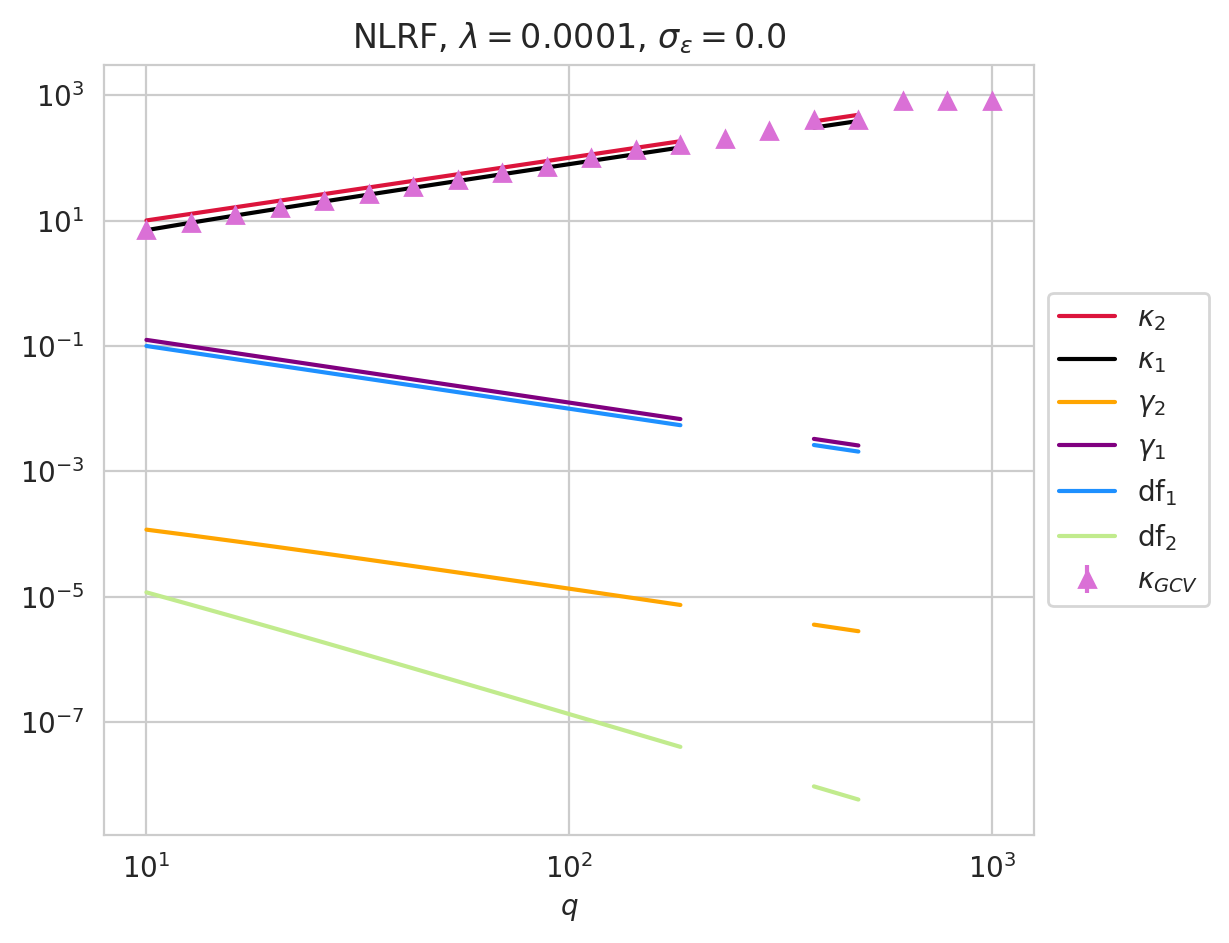

In [12]:
# q is D/P
qs2 = qs 
kappa2 = jnp.array([solve_kappa2(D/q, D, N, lamb=lamb, sigma=sigma_xi, etaX=etasX) for q in qs2])
df1k2 = jnp.array([df_1_bar(etasX, k, sigma_xi) for k in kappa2])
df2k2 = jnp.array([df_2(etasX, k) for k in kappa2])
tf1pk2 = jnp.array([tf_1p(etasX, w, k) for k in kappa2])
tf1k2 = jnp.array([tf_1(etasX, w, k) for k in kappa2])
tf2k2 = jnp.array([tf_2(etasX, w, k) for k in kappa2])
gamma2 = qs2 * df2k2
kappa1 = kappa2 * (N/D - df1k2)
dlogS = df1k2/(N/D - df1k2)
dlogk1k2 = 1 + (df1k2-df2k2)/df1k2 * dlogS
dlogk2k1 = 1/dlogk1k2

gamma1 = qs2 * df1k2 * (1 - (df1k2 - df2k2)/df1k2 * dlogk2k1)

kappaGCV = np.array([np.mean(kappa_emp_guess[q]) for q in qs])
kappaGCV_std = np.array([np.std(kappa_emp_guess[q]) for q in qs])
Ss_emp_std = np.array([np.std(kappa_emp_guess[q]) for q in qs])/lamb

sns.set_palette('rainbow', n_colors=7)
plt.figure(figsize=(6, 5))
plt.plot(qs2, kappa2, label="$\\kappa_2$", c='crimson')
plt.plot(qs2, kappa1, label="$\\kappa_1$", c='k')
plt.errorbar(qs, kappaGCV, kappaGCV_std, label="$\\kappa_{GCV}$", c='orchid', marker='^', linestyle="")

plt.plot(qs2, gamma2, label="$\\gamma_2$", c='orange')
plt.plot(qs2, gamma1, label="$\\gamma_1$", c='purple')

plt.plot(qs2, df1k2, label="df$_1$", c='dodgerblue')
plt.plot(qs2, df2k2, label="df$_2$", c='C4')

# plt.plot(qs2, dlogk2k1, label="dlogk2k1", c='C1')

# plt.errorbar(qs2, [np.mean(df1_empirical[q]) for q in qs], [np.std(df1_empirical[q]) for q in qs] , marker='o', linestyle="", label="df$_1$ emp", c='C6')

# plt.plot(qs, Ss, c='forestgreen', label="$S$")
# plt.errorbar(qs, Ss_emp, Ss_emp_std, marker='o', linestyle='', c='forestgreen', label='$S$ emp')
# Put the legent to the right of the actual plot:
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$q$')
plt.title(f"NLRF, $\\lambda=${lamb}, $\\sigma_\\epsilon=${sigma_epsilon}")

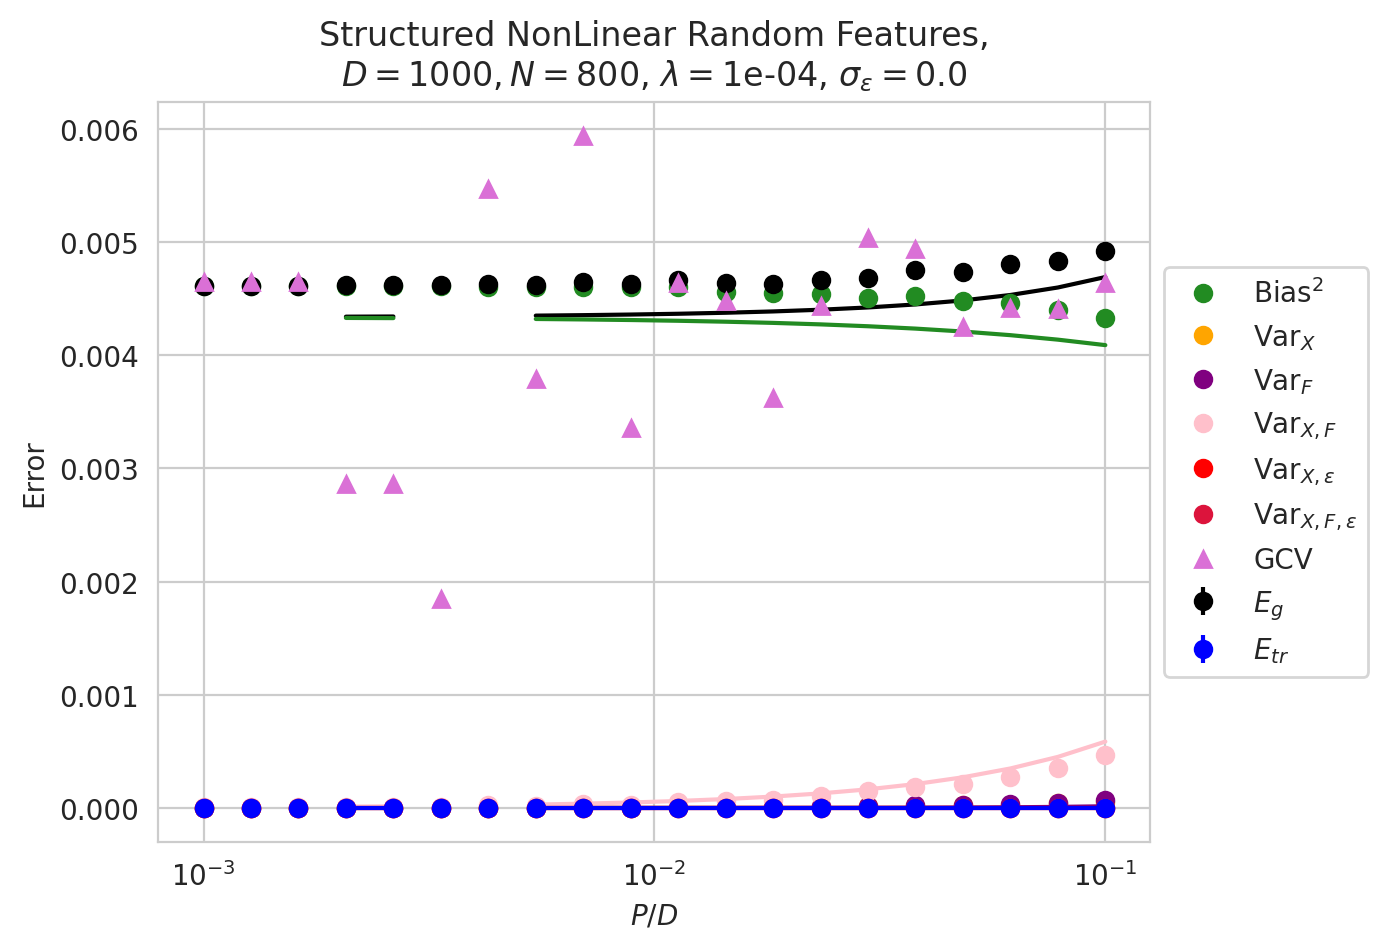

: 

In [16]:
Eg_means = np.array([np.mean(Egs[q]) for q in qs])
Eg_stds = np.array([np.std(Egs[q]) for q in qs])/10
Etr_means = np.array([np.mean(Etrs[q]) for q in qs])
Etr_stds = np.array([np.std(Etrs[q]) for q in qs])

signal = (kappa2**2 * tf1pk2 * dlogk2k1 + kappa2*tf1k2 * ( 1 - dlogk2k1) ) /(1-gamma1)
noise = sigma_epsilon**2 * gamma1/(1-gamma1)
Eg_theory = signal + noise
bias = kappa2**2 * tf1pk2
varX = kappa2**2 * tf1pk2 * gamma2/(1-gamma2)
varXe = sigma_epsilon**2 * gamma2/(1-gamma2)
varXFe = noise - varXe
varF = (1 - dlogk2k1) * kappa2 * tf2k2
varXF = signal - varX - varF - bias

Etr_theory = ((lamb/kappa1)**2)*(Eg_theory + sigma_epsilon**2)

plt.errorbar(1/qs, Eg_means, Eg_stds, c='k', marker='o', linestyle='', label='$E_{g}$')
plt.plot(1/qs2,  Eg_theory, c='k')
# plt.plot(qs, (np.array(kappaGCV)/lamb)**2 * ((lamb/kappa)**2)*(Eg_theory + sigma_epsilon**2)  - sigma_epsilon**2 , c='grey', marker='o', linestyle='', label='GCV')

plt.plot(1/qs2, bias, c='forestgreen')
plt.plot(1/qs, Biases, c='forestgreen', marker='o', linestyle='', label="Bias$^2$")
plt.plot(1/qs2, varX, c='orange')
plt.plot(1/qs, VarXs, c='orange', marker='o', linestyle='', label='Var$_{{X}}$')
plt.plot(1/qs2, varF, c='purple')
plt.plot(1/qs, VarFs, c='purple', marker='o', linestyle='', label='Var$_{{F}}$')
plt.plot(1/qs2, varXF, c='pink')
plt.plot(1/qs, VarXFs, c='pink', marker='o', linestyle='', label='Var$_{{X, F}}$')
plt.plot(1/qs2, varXe, c='red')
plt.plot(1/qs, VarXes, c='red', marker='o', linestyle='', label='Var$_{{X, \epsilon}}$')
plt.plot(1/qs2, varXFe, c='crimson')
plt.plot(1/qs, VarXFes, c='crimson', marker='o', linestyle='', label='Var$_{{X, F, \epsilon}}$')


plt.plot(1/qs, (np.array(kappaGCV)/lamb)**2 * Etr_means - sigma_epsilon**2 , c='orchid', marker='^', linestyle='', label='GCV', zorder=3)

plt.errorbar(1/qs, Etr_means, Etr_stds, c='b', marker='o', linestyle='', label='$E_{tr}$')
plt.plot(1/qs2, Etr_theory, c='b')


plt.xlabel(r'$P/D$')
plt.ylabel('Error')
# plt.xlim(1, 1e2) 
# plt.ylim(1e-7, 1e2)
plt.xscale('log')
# plt.yscale('log')
plt.title(f"Structured NonLinear Random Features,\n$D={D}, N={N}$, $\\lambda=${lamb:.0e}, $\\sigma_\\epsilon=${sigma_epsilon}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))